# start

In [1]:
#########################
PRFX = 'MelInf0726B1'#
PRFX_B4 = 'Mel0726B1'
#########################
N_TTA=8
p_b4 = f'../output/{PRFX_B4}'

BS = 4

class Param: pass
import pickle
res_b4 = pickle.load(open(f'{p_b4}/results_{PRFX_B4}.p', 'rb'))
param = res_b4['param']
param.__dict__

{'PRFX': 'Mel0726B1',
 'F_PSD': None,
 'PRFX_B4': None,
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'PRFX_PREP': 'MelPrp0909A224',
 'LASTM': 3,
 'BS': 40,
 'SEED': 101,
 'EPOCHS': 10,
 'K': 4,
 'FLDS2USE': range(0, 4),
 'FP16': True,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
DEVICE = 'cuda'; 
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

In [3]:
!nvidia-smi

Mon Jul 27 14:40:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   67C    P0   213W / 300W |  15848MiB / 16160MiB |     99%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [4]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

# import pretrainedmodels
from efficientnet_pytorch import EfficientNet
# import geffnet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'

# prep

In [5]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

if param.N_SAMPL is not None: dftrn = dftrn.sample(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
0,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_7279968,0.0
1,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_3075186,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [19]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

0


In [20]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 43524 14508
1 43524 14508
2 43524 14508
3 43524 14508


0.0    0.910739
1.0    0.089261
Name: target, dtype: float64

0.0    0.911704
1.0    0.088296
Name: target, dtype: float64

0.0    0.911221
1.0    0.088779
Name: target, dtype: float64

0.0    0.914599
1.0    0.085401
Name: target, dtype: float64

20    24544
19    18980
Name: source, dtype: int64

20    24521
19    19003
Name: source, dtype: int64

20    24435
19    19089
Name: source, dtype: int64

20    24603
19    18921
Name: source, dtype: int64

In [21]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [22]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

14508 8157
14508 8180
14508 8266
14508 8098


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if self.mode != 'trn':
            self.composed = A.Compose([
                A.Resize(param.SZ,param.SZ),
                A.Normalize(), 
                AT.ToTensor(),
            ]) 
        else:
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.RandomBrightnessContrast(),
#                 A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
#                 A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=3),
#                 A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode !='tst':
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
if param.DEBUG: 
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)

In [12]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

# train

## TTA

In [14]:
# Diheral TTA outside dataloader
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

def evaluate(model, dl):
    model.eval()
    prd = []
    y = []   
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        y.append(yb.cpu().detach().numpy())
        with torch.no_grad(): 
            for I in range(N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [15]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        xb=dat[0].to(device)
        with torch.no_grad(): 
            for I in range(N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    

    return prd

## set up data

In [16]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    cols2use=['im_pth', 'target']
    if param.F_PSD is not None:
        dftr= pd.concat([dftrn[cols2use].iloc[tr], dfpsd[cols2use]])
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dltr = DataLoader(dstr, batch_size=BS,   shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    return dltr,dlvl

## run val

In [17]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param
results['fld2stats']={}

In [18]:
for fld in param.FLDS2USE:    
    tr,vl=fld2trvl[fld]
    dltr,dlvl=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl:', len(dltr), len(dlvl))

    mdl = mkmdl().to(device)

    stats = {
    'lss': {'tr':[],'vl':[],},
    'scr': {'tr':[],'vl':[],},
    }
    ep2oof = []
    best_scr = float('-inf')
    best_epc = -1    
    
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        fnm_mdl_b4 = f'{p_b4}/model_{PRFX_B4}_fld_{fld}_epc_{epc}.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_vl {lss_vl_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc

        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))  
        
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'wb'))  

fld:0; dltr,dlvl: 10881 1814
Loaded pretrained weights for efficientnet-b0
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_0_epc_7.p
2020-07-27 01:17:57 fld 0 ep 7: lss_vl 0.270; scr_vl 0.915; 
better scr -inf -> 0.915
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_0_epc_8.p
2020-07-27 01:22:35 fld 0 ep 8: lss_vl 0.252; scr_vl 0.920; 
better scr 0.915 -> 0.920
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_0_epc_9.p
2020-07-27 01:27:22 fld 0 ep 9: lss_vl 0.255; scr_vl 0.916; 
fld:1; dltr,dlvl: 10881 1814
Loaded pretrained weights for efficientnet-b0
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_1_epc_7.p
2020-07-27 01:32:01 fld 1 ep 7: lss_vl 0.271; scr_vl 0.922; 
better scr -inf -> 0.922
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_1_epc_8.p
2020-07-27 01:36:38 fld 1 ep 8: lss_vl 0.260; scr_vl 0.929; 
better scr 0.922 -> 0.929
load previously trained ../output/Mel0726B1/model_Mel0726B1_fld_1_epc_9.p

In [19]:
pickle.dump(results, open(f'{p_out}/results_{PRFX}.p', 'wb'))  

# training trajec

In [20]:
for fld,stats in results['fld2stats'].items():
    print(f"fld {fld} best_epc: {stats['best_epc']}; best_scr: {stats['best_scr']:.4f};")

fld 0 best_epc: 8; best_scr: 0.9197;
fld 1 best_epc: 9; best_scr: 0.9317;
fld 2 best_epc: 8; best_scr: 0.9232;
fld 3 best_epc: 9; best_scr: 0.9233;


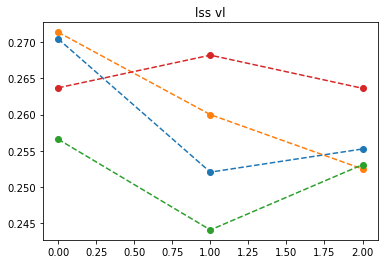

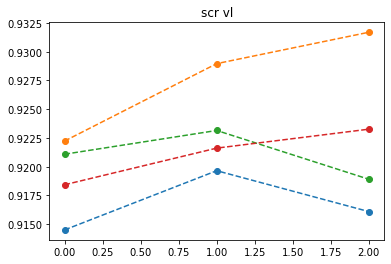

In [26]:
for mtrc in ['lss', 'scr']:
    for k in ['vl',]:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [23]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 1, 4, 6, 10, 15, 17, 19, 21, 29])

## only last epoch 

In [23]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.9224646357842959

In [24]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.8970695359270205

## only best_scr epoch

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc =  results['fld2stats'][fld]['best_epc'] - (param.EPOCHS - param.LASTM)
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9238251374775285

In [26]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.898195128852003

## avg last m epochs

In [28]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.9239751837459598

In [29]:
roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])

0.8991285369194265

In [41]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [43]:
for m in range(1,param.LASTM+1):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.4f}', )

1 0.9225
2 0.9244
3 0.9240


In [44]:
for m in range(1, param.LASTM+1):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    auc20=roc_auc(dftrn.target.iloc[[o for o in vls if o in idx20]],
        [o[0] for o in zip(oofs,vls) if o[1] in idx20])
    print(m, f'{auc20:.4f}')


1 0.8971
2 0.8998
3 0.8991


# Inference

In [45]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909A224/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909A224/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909A224/siim-isic-melanoma-cl...


10982
1373


In [47]:
# avg last m epochs
mdl = mkmdl().to(device)
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        mdl.load_state_dict(torch.load(f'{p_b4}/model_{PRFX}_fld_{fld}_epc_{epc}.p'))
        prdtst = infer(mdl, dltst)
        dfsub.target = sigmoid(prdtst)
        dfsub.to_csv(f'{p_out}/submission_{PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
        print(dtnow(), f'fld {fld} ep {epc}', f'{dfsub.target.mean():.4f}')


Loaded pretrained weights for efficientnet-b0
2020-07-27 02:19:26 step 0/1373
2020-07-27 02:22:00 step 1000/1373
2020-07-27 02:22:56 fld 0 ep 7 0.1511
2020-07-27 02:22:57 step 0/1373
2020-07-27 02:25:31 step 1000/1373
2020-07-27 02:26:28 fld 0 ep 8 0.1352
2020-07-27 02:26:29 step 0/1373
2020-07-27 02:29:12 step 1000/1373
2020-07-27 02:30:08 fld 0 ep 9 0.1406
2020-07-27 02:30:09 step 0/1373
2020-07-27 02:32:42 step 1000/1373
2020-07-27 02:33:39 fld 1 ep 7 0.1638
2020-07-27 02:33:39 step 0/1373
2020-07-27 02:36:12 step 1000/1373
2020-07-27 02:37:09 fld 1 ep 8 0.1614
2020-07-27 02:37:09 step 0/1373
2020-07-27 02:39:40 step 1000/1373
2020-07-27 02:40:38 fld 1 ep 9 0.1579
2020-07-27 02:40:39 step 0/1373
2020-07-27 02:43:14 step 1000/1373
2020-07-27 02:44:12 fld 2 ep 7 0.1589
2020-07-27 02:44:13 step 0/1373
2020-07-27 02:46:55 step 1000/1373
2020-07-27 02:47:52 fld 2 ep 8 0.1408
2020-07-27 02:47:53 step 0/1373
2020-07-27 02:50:25 step 1000/1373
2020-07-27 02:51:21 fld 2 ep 9 0.1488
2020-07-2

fld 0 epc 7 0.1511
fld 0 epc 8 0.1352
fld 0 epc 9 0.1406
fld 1 epc 7 0.1638
fld 1 epc 8 0.1614
fld 1 epc 9 0.1579
fld 2 epc 7 0.1589
fld 2 epc 8 0.1408
fld 2 epc 9 0.1488
fld 3 epc 7 0.1526
fld 3 epc 8 0.1597
fld 3 epc 9 0.1563

0.1522601031080427


,image_name,target
0,ISIC_0052060,0.059552
1,ISIC_0052349,0.058035
2,ISIC_0058510,0.047833


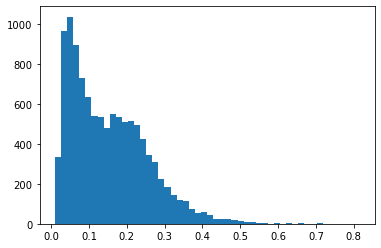

In [48]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-param.LASTM, param.EPOCHS):
        sub_fld_epc = pd.read_csv(f'{p_out}/submission_{PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, f'{sub_fld_epc.target.mean():.4f}')
        lst_sub.append(sub_fld_epc.target.values)
print()
sub = np.mean(lst_sub, 0)
print(sub.mean())
dfsub.target = sub

display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [49]:
dfsub.to_csv(f'{p_out}/submission_{PRFX}_avglast{param.LASTM}.csv', index=False)

# fin

In [50]:
param.__dict__

{'PRFX': 'Mel0726B1',
 'F_PSD': None,
 'PRFX_B4': None,
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'PRFX_PREP': 'MelPrp0909A224',
 'LASTM': 3,
 'BS': 40,
 'SEED': 101,
 'EPOCHS': 10,
 'K': 4,
 'FLDS2USE': range(0, 4),
 'FP16': True,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [51]:
!nvidia-smi

Mon Jul 27 03:15:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   62C    P0   114W / 300W |  16122MiB / 16160MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  